# see Danieles Mail from 28.01.25

In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import UubRandoms

18:56:55 (  +441ms) [INFO   ] -- import logging
18:56:55 (   +74ms) [INFO   ] -- import numpy as np
18:56:55 (   +17ms) [INFO   ] -- import uncertainties
18:56:56 (  +214ms) [INFO   ] -- import pandas as pd
18:56:56 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
18:56:56 (    +1ms) [INFO   ] -- import binaries.tools as tools
18:56:56 (  +366ms) [INFO   ] -- import matplotlib.pyplot as plt
18:56:57 (  +515ms) [INFO   ] -- import seaborn as so
18:56:57 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
18:56:57 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
18:56:57 (    +0ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
18:56:57 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
18:56:57 (    +0ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
18:56:57 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offline/in

ModuleNotFoundError: No module named 'utils.Auger'

In [2]:
RandomFiles = UubRandoms.UubRandom(station = "Svenja", detectors = "ssd")

px = np.zeros(10000)
pulse_heights = []

for File in tools.ProgressBar(RandomFiles):
    for trace in File:

        _max = np.max(trace['trace'])
        px[_max] += 1

        if _max >= 70:
            pulse_heights.append(_max)

tools.pickle_save('pulse_height_distribution.pkl', px)
print(f"{np.mean(pulse_heights) = :.4f}")
print(f"{np.std(pulse_heights) = :.4f}")

KeyboardInterrupt: 

In [3]:
px = tools.pickle_load('pulse_height_distribution.pkl')

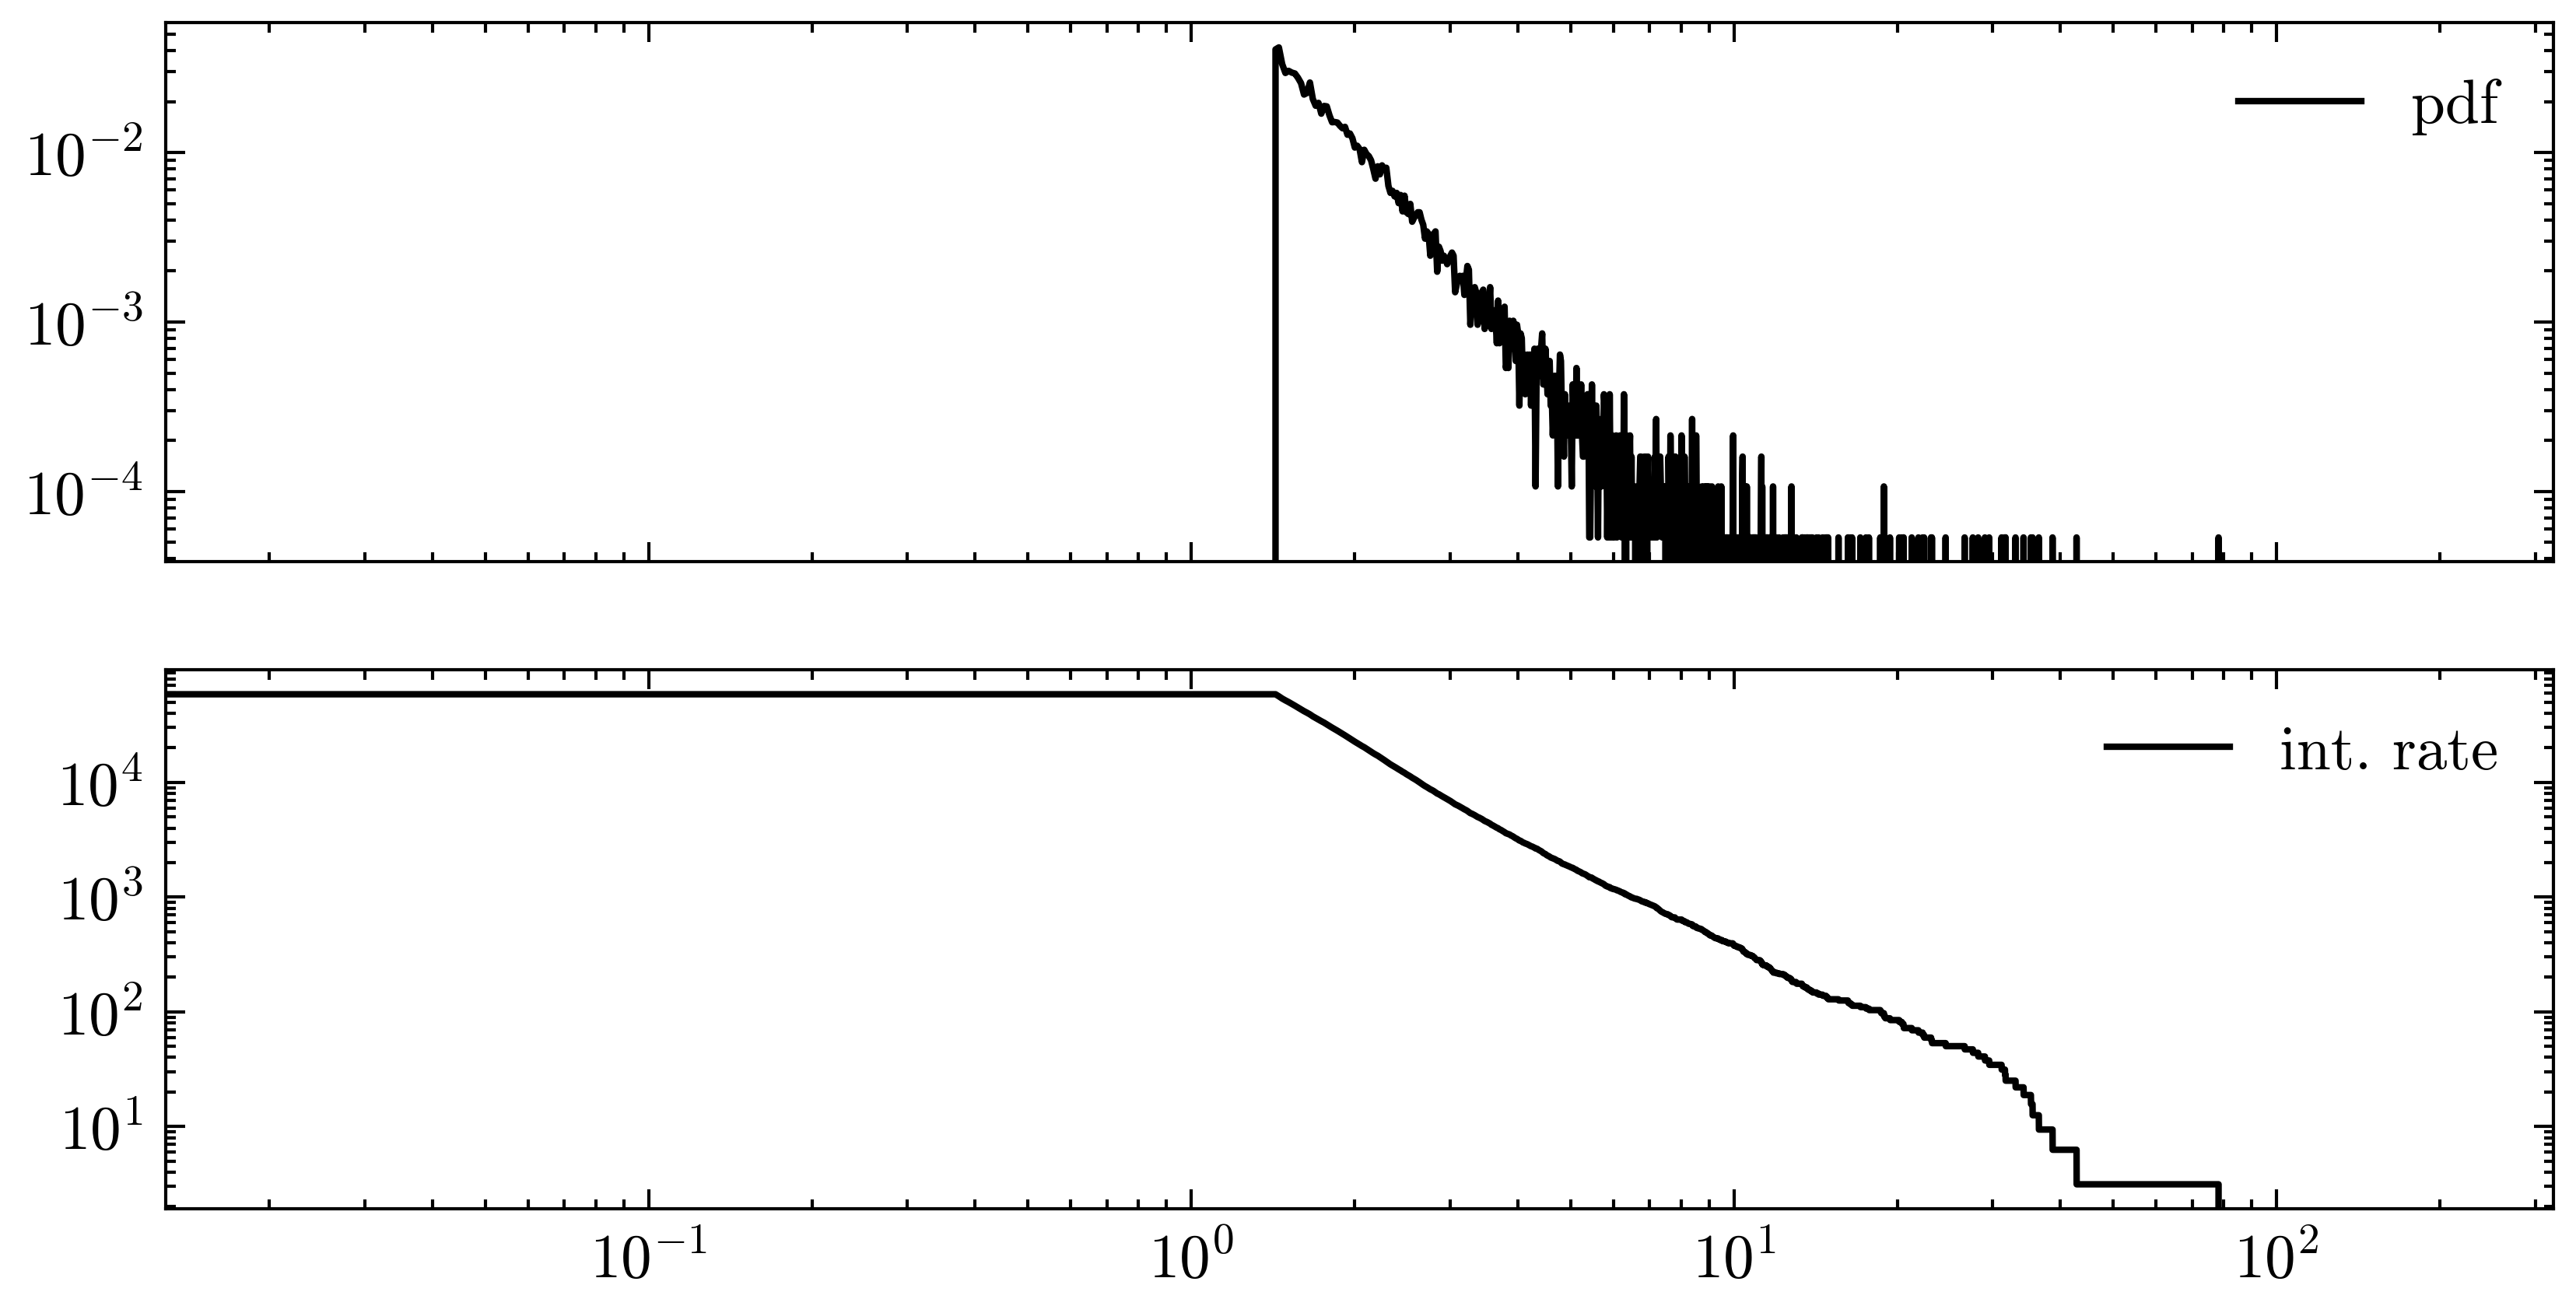

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

px[:70] = 0
cumsum = np.cumsum(px[::-1])[::-1]

ax1.plot(range(10000) / trace['mip_peak'], px/cumsum[0], label='pdf')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()

ax2.plot(range(10000) / trace['mip_peak'], cumsum / (cumsum[0] * 2048 * 8.33e-9), label='int. rate')
ax2.set_yscale('log')
ax2.legend()

/tmp/ipykernel_62807/3255336303.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title=fr"$\chi_\nu^2$ = {np.sum((y - exponential_corrected(x, *popt))**2 / ERROR**2 / NDOF):.2f}")


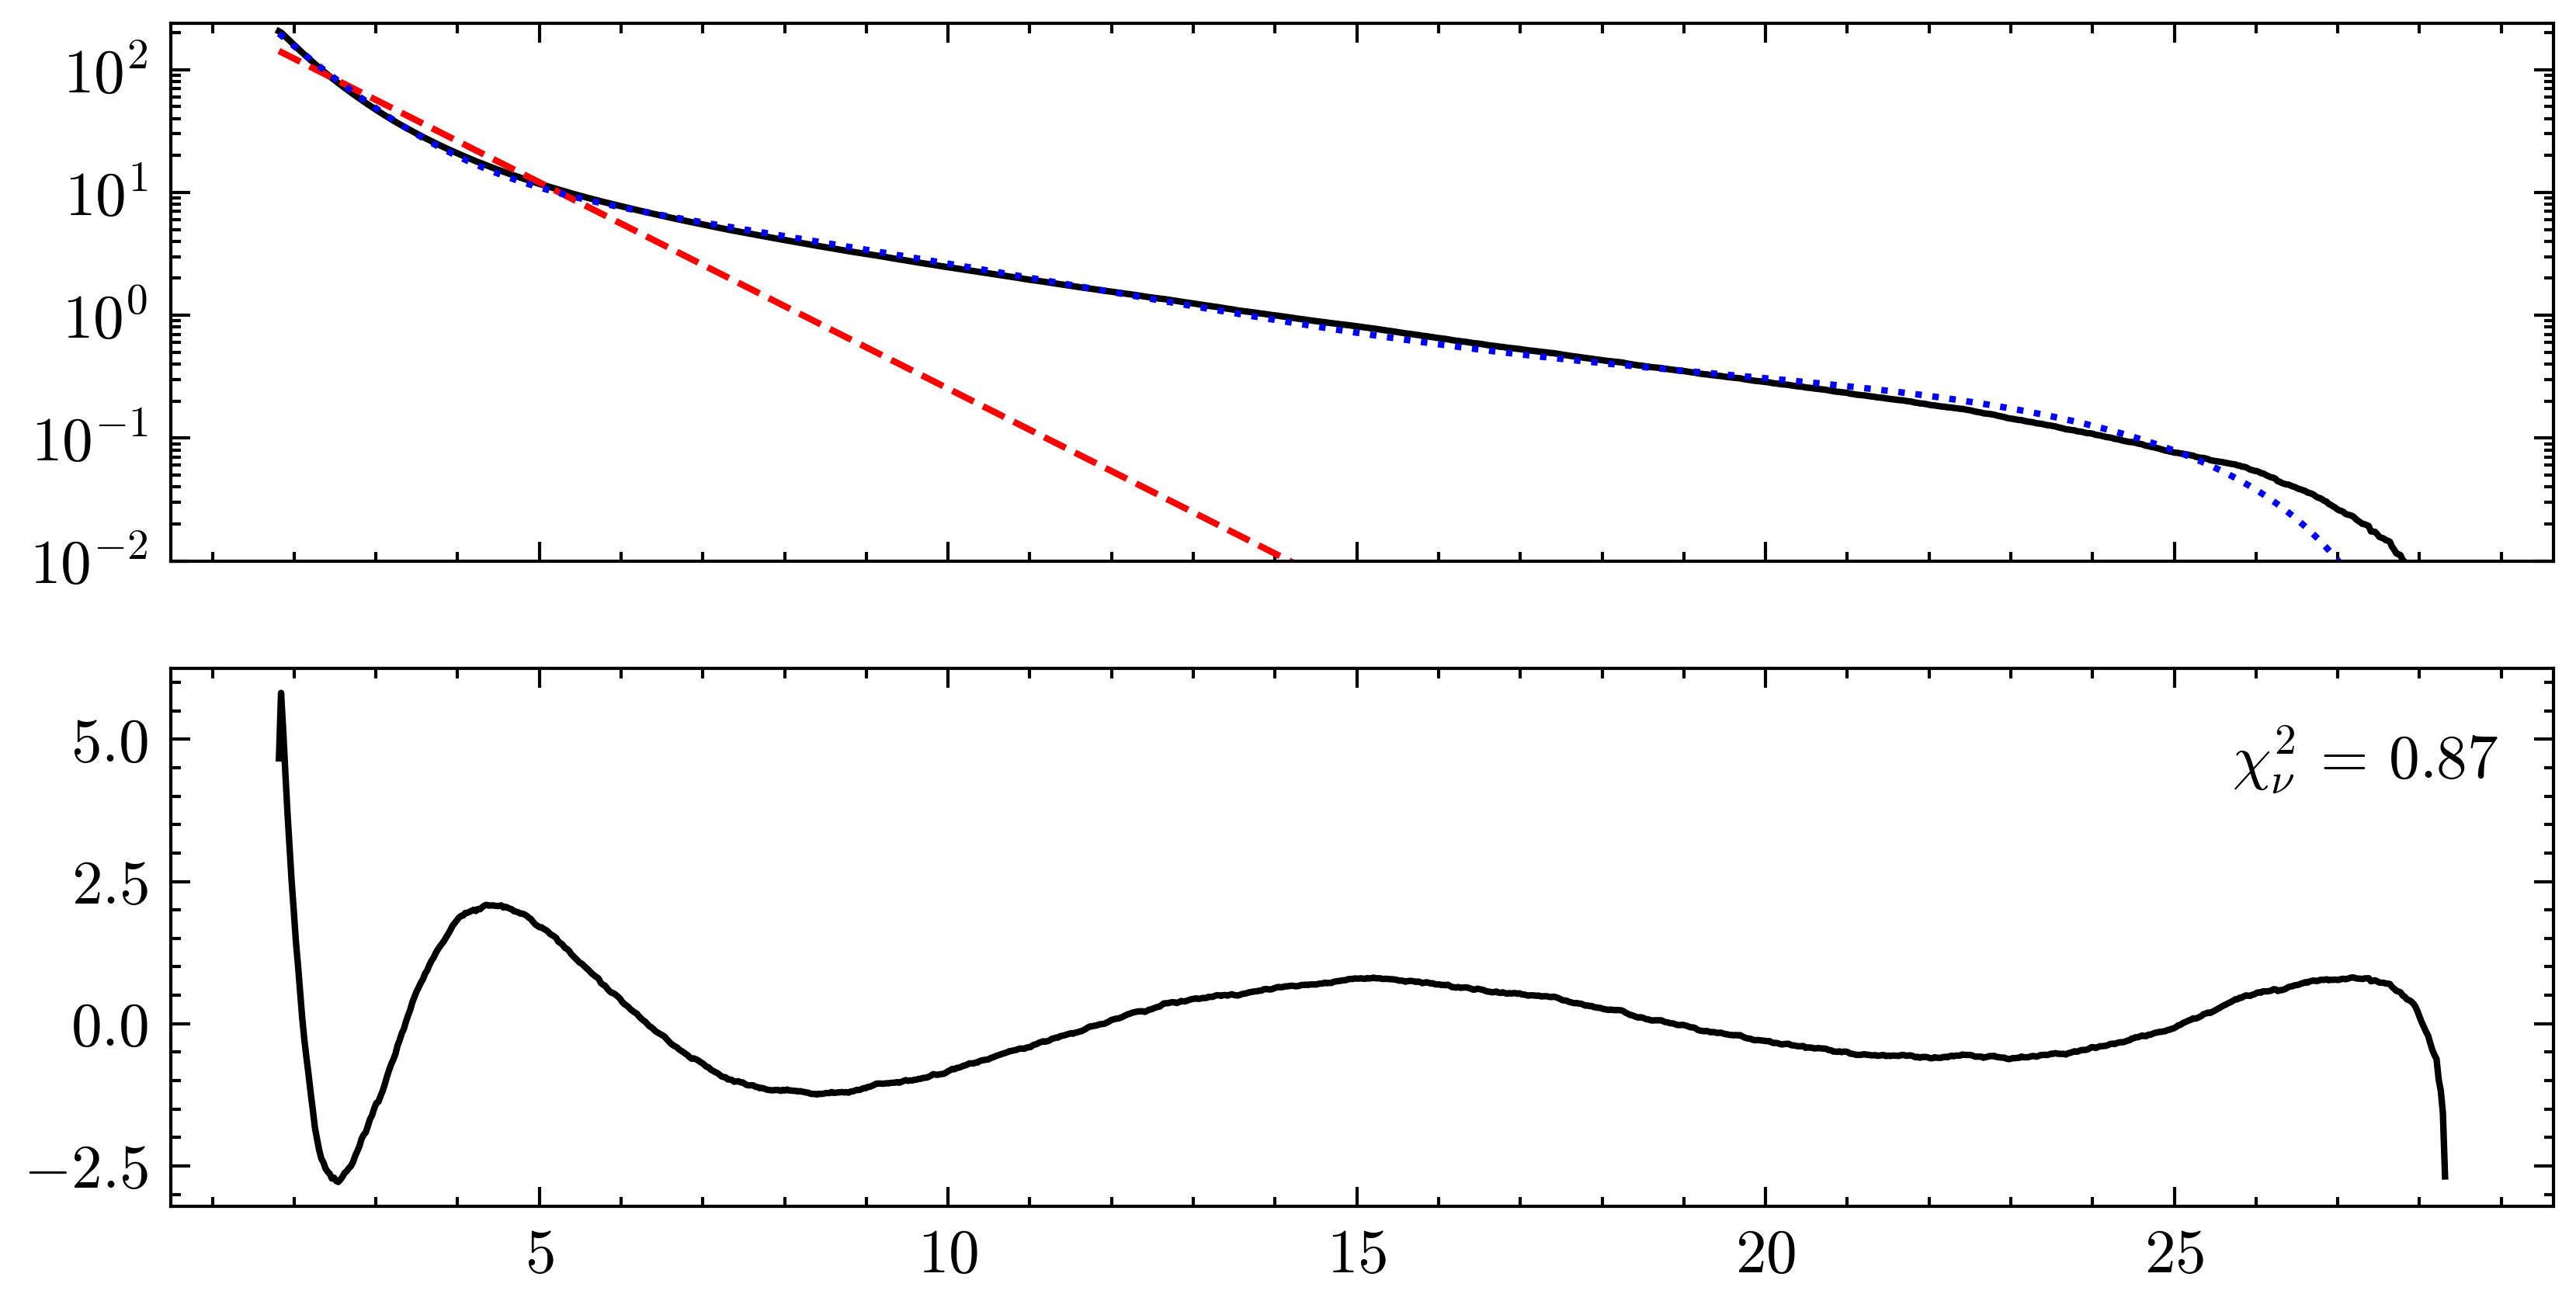

In [3]:
# fitting rate-threshold relationship

from scipy.optimize import curve_fit

def exponential(x, A, mu):
    return A * np.exp(x * mu)

def exponential_corrected(x, A, mu, c, d, e, f, g):
    return A * np.exp(x * mu) + np.poly1d([c, d, e, f, g])(x)

x, y = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
ERROR = np.sqrt(y / 60)
NDOF = len(x) - 7
bounds_low = [0, -np.inf] + [-np.inf] * 5
bounds_high = [np.inf, 0] + [np.inf] * 5

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y, marker='none')
popt, pcov = curve_fit(exponential, x, y,
                       sigma=ERROR,
                       bounds=(bounds_low[:2], bounds_high[:2]))
ax1.plot(x, exponential(x, *popt), marker='none')

popt, pcov = curve_fit(exponential_corrected, x, y,
                       sigma=ERROR,
                       bounds=(bounds_low, bounds_high))


ax1.plot(x, exponential_corrected(x, *popt), marker='none')
ax1.set_ylim(0.01, 240)
ax1.set_yscale('log')

ax2.plot(x, (y - exponential_corrected(x, *popt)) / ERROR)
ax2.legend(title=fr"$\chi_\nu^2$ = {np.sum((y - exponential_corrected(x, *popt))**2 / ERROR**2 / NDOF):.2f}")
# ax2.set_yscale('log')

In [5]:
X_TARGET = 5
Y_TARGET = 10

print(X_TARGET, y[np.argmin(np.abs(x-X_TARGET))])
print(x[np.argmin(np.abs(y-Y_TARGET))], Y_TARGET)

5 11.741083333333332
5.362840541172009 10


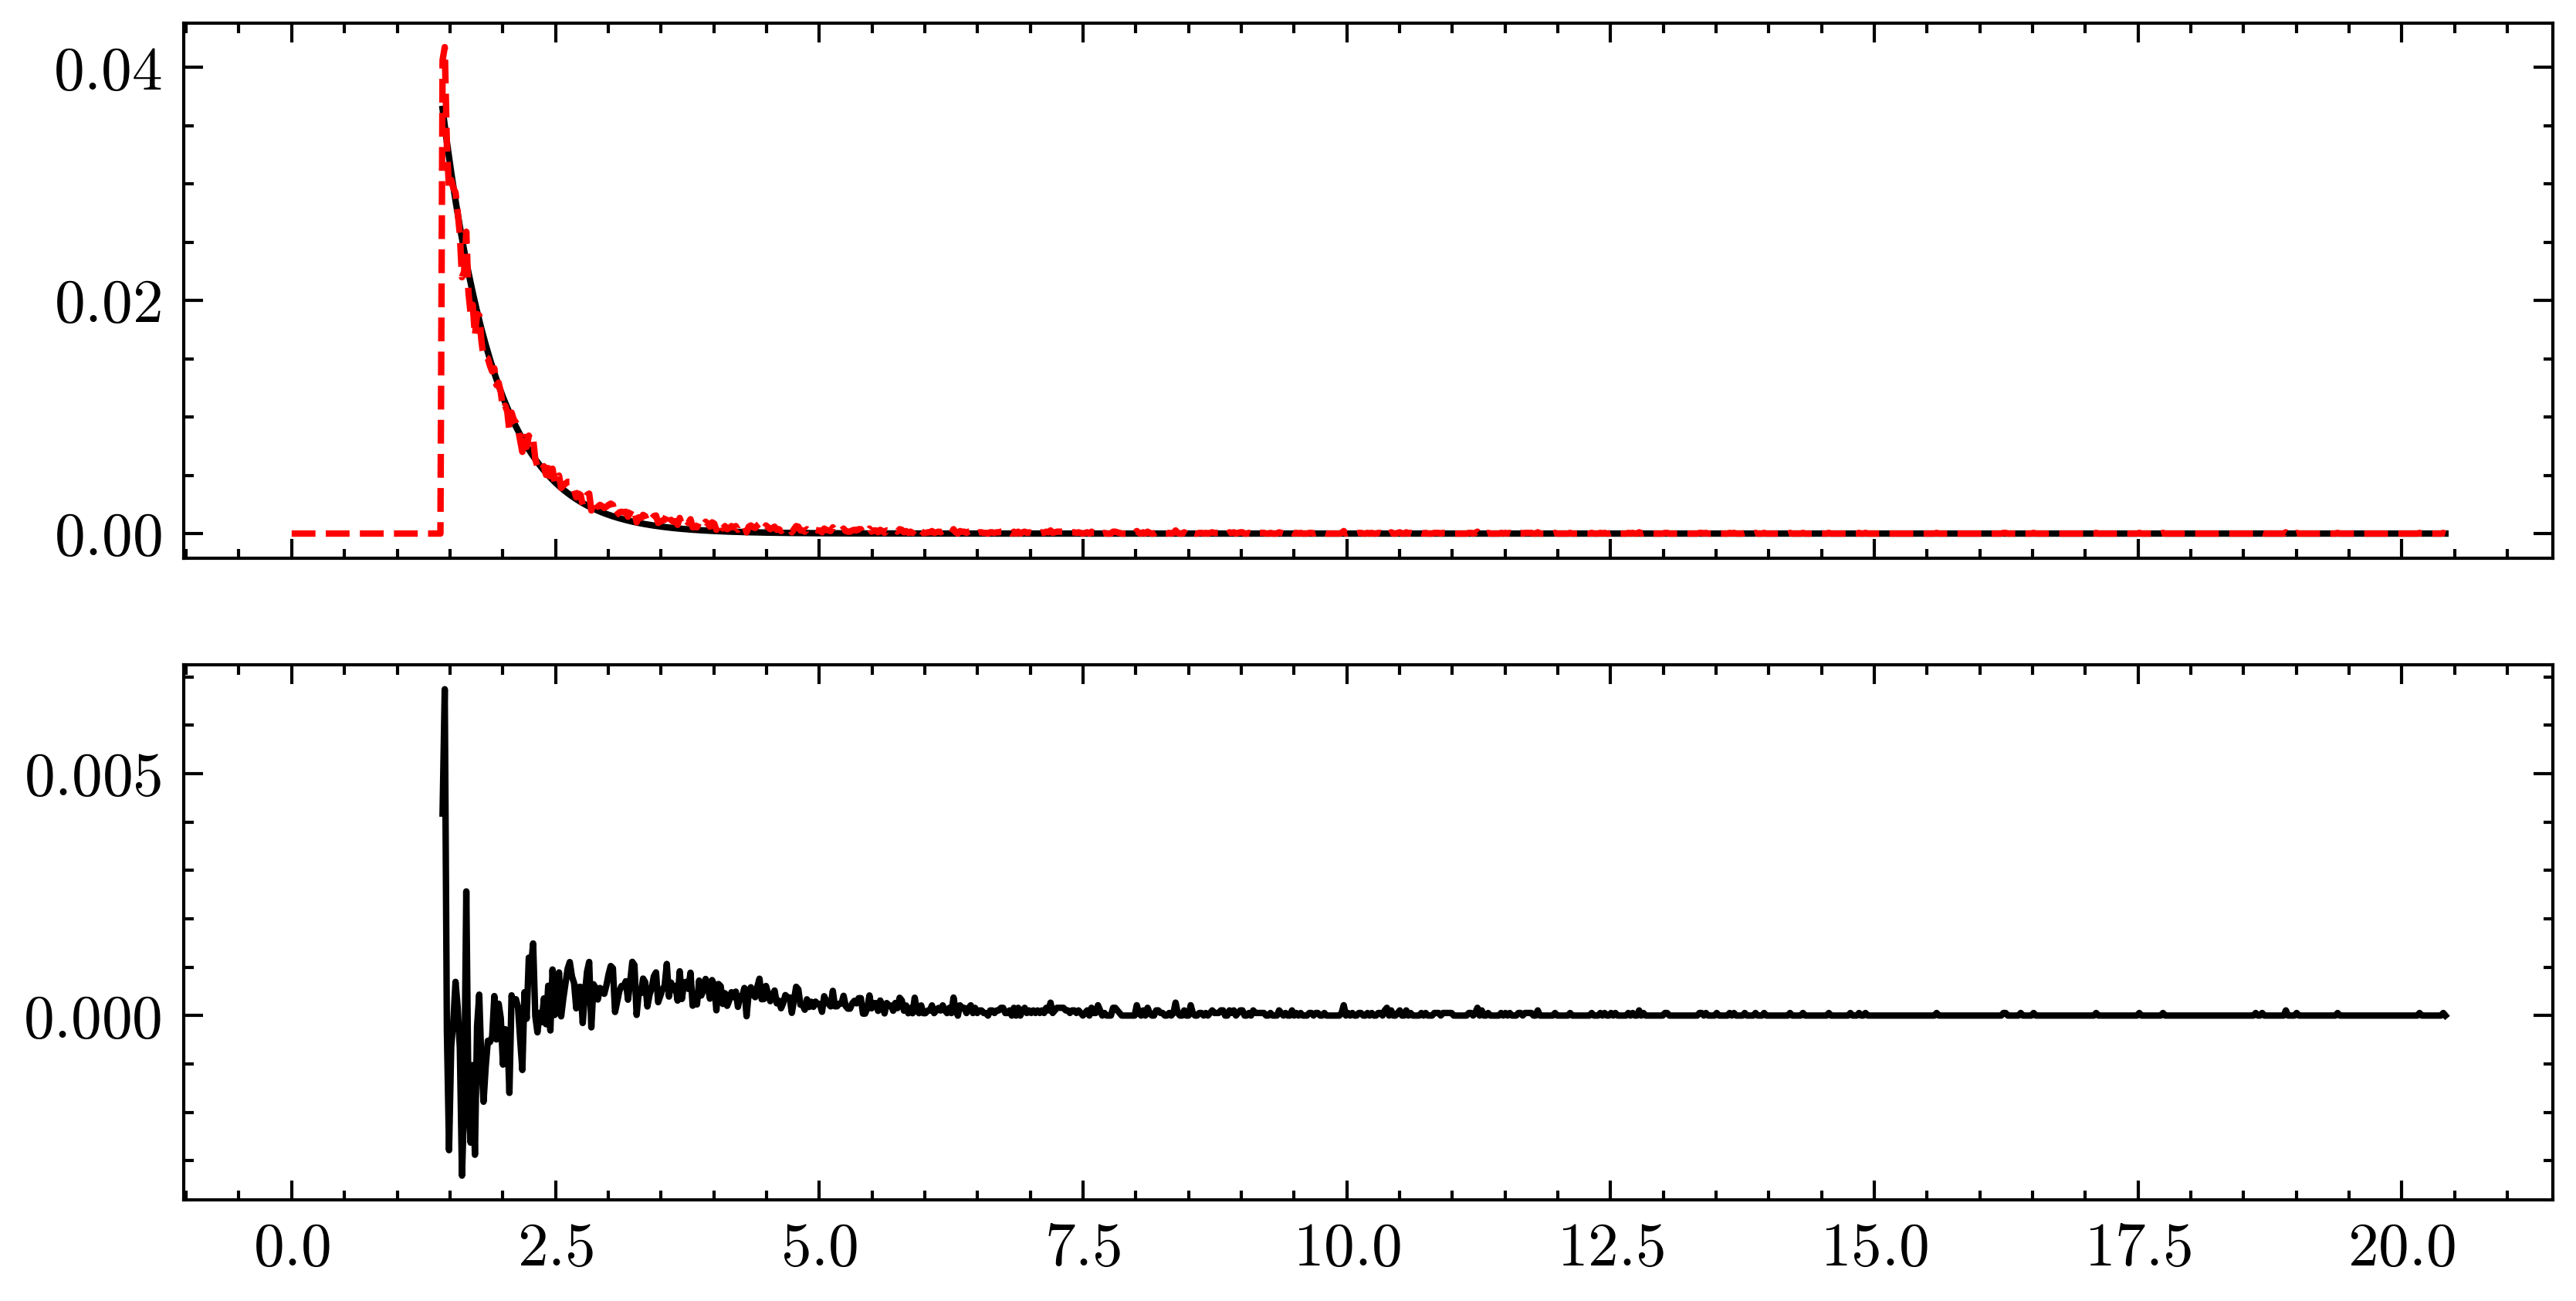

In [6]:
def pdf(x, a, mu):
    return a * np.exp(x*mu)

popt_pdf, pcov = curve_fit(pdf, np.arange(70,1000)/48.94, px[70:1000]/cumsum[0],
                       bounds=([0, -np.inf],[np.inf, 0]))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

X = np.arange(70, 1000) / trace['mip_peak']
ax1.plot(X, pdf(X, *popt_pdf))
ax1.plot(range(1000) / trace['mip_peak'], px[:1000]/cumsum[0], marker='none')

ax2.plot(range(70,1000) / trace['mip_peak'], px[70:1000]/cumsum[0] - pdf(X, *popt_pdf), marker='none')

In [7]:
x  = range(10000) / trace['mip_peak']
px = popt_pdf #px/cumsum[0]
fx = popt #lambda x: exponential_corrected(x, *popt)

tools.pickle_save('x_px_fx.pkl', [x, px, fx])

In [ ]:
trace['mip_peak']

(0.0, 1000.0)

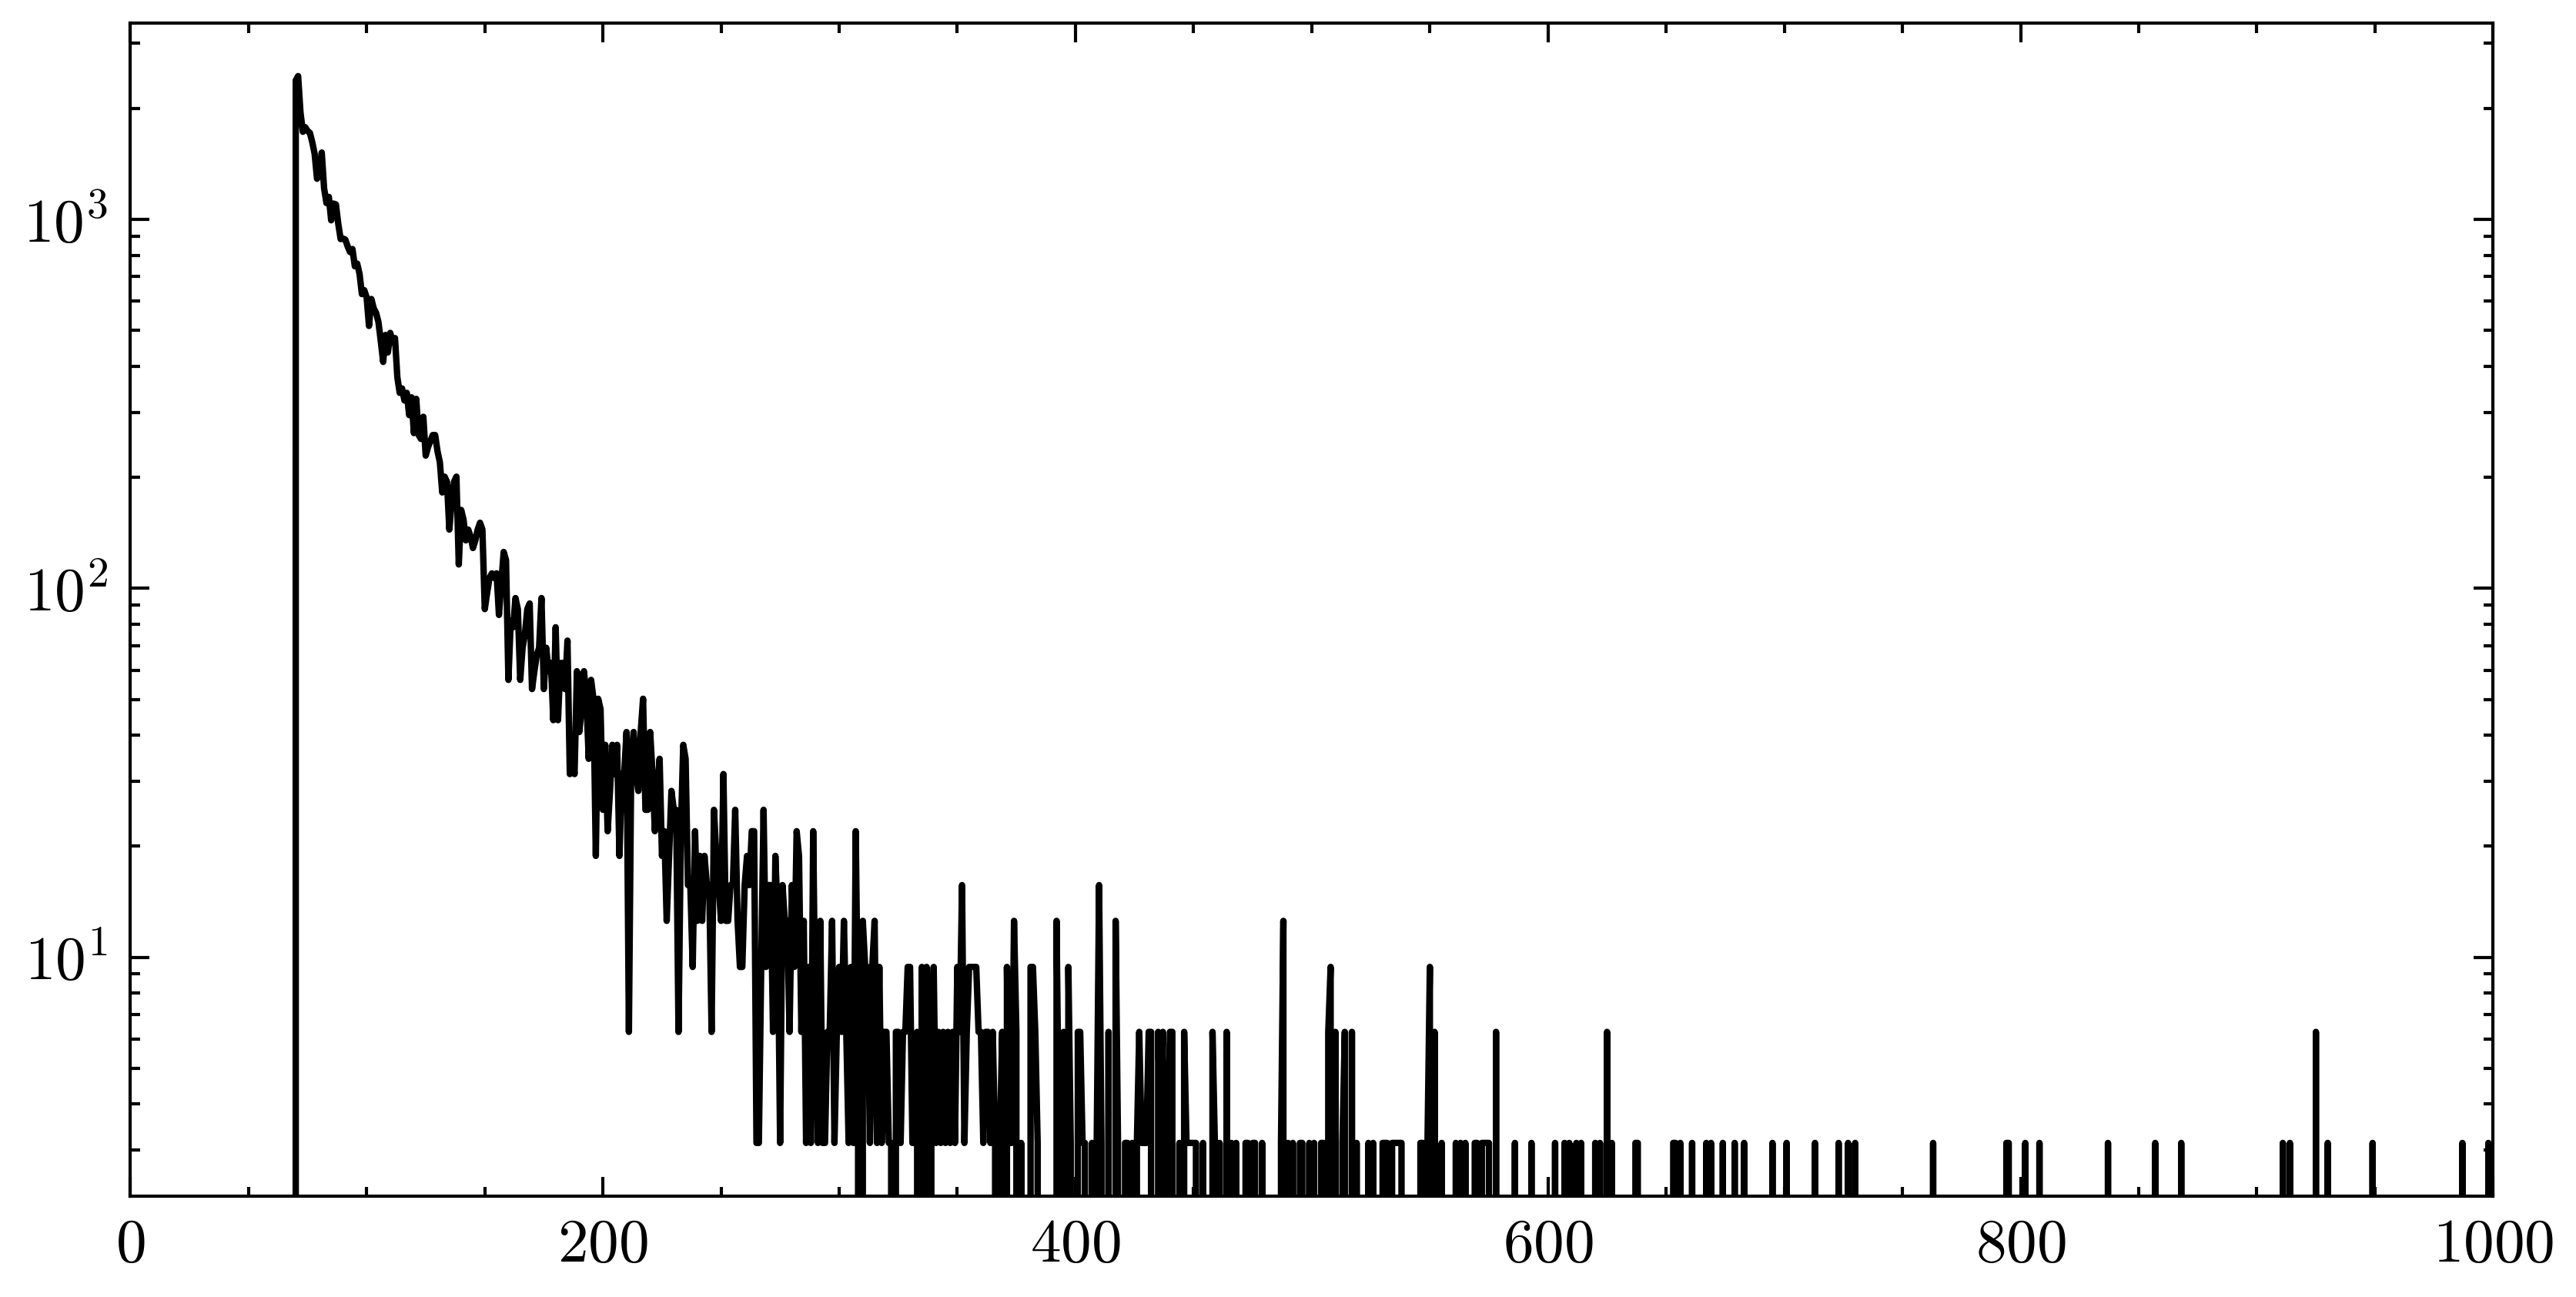

In [11]:
plt.plot(range(len(px)), px / (cumsum[0] * 2048 * 8.33e-9))
plt.yscale('log')
plt.xlim(0, 1000)

In [12]:
trace['mip_peak']

48.94